In [14]:
import pandas as pd
import numpy as np
import datetime as dt
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import summary_data_from_transaction_data as summary
df = pd.read_csv("flo_data_20k.csv")
df.head()   

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR]


In [15]:
df.describe()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online
count,19945.000000,19945.000000,19945.000000,19945.000000
mean,3.110855,1.913913,253.922597,497.321690
std,4.225647,2.062880,301.532853,832.601886
min,1.000000,1.000000,10.000000,12.990000
25%,1.000000,1.000000,99.990000,149.980000
50%,2.000000,1.000000,179.980000,286.460000
75%,4.000000,2.000000,319.970000,578.440000
max,200.000000,109.000000,18119.140000,45220.130000


In [16]:
def outier_threshold(df,variable):
    q1 = df[variable].quantile(0.01)
    q3 = df[variable].quantile(0.99)
    iqr = q3 - q1
    lower_limit = df[variable].quantile(0.25) - 1.5*iqr
    upper_limit = df[variable].quantile(0.75) + 1.5*iqr
    
    df[variable].clip(upper=upper_limit, lower=lower_limit,inplace=True)
    

outier_threshold(df,"order_num_total_ever_online") 
outier_threshold(df,"order_num_total_ever_offline") 
outier_threshold(df,"customer_value_total_ever_offline") 
outier_threshold(df,"customer_value_total_ever_online") 

In [18]:
df.describe()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online
count,19945.000000,19945.000000,19945.00000,19945.000000
mean,3.073151,1.878416,250.80245,486.683728
std,3.628782,1.372217,240.63791,604.381435
min,1.000000,1.000000,10.00000,12.990000
25%,1.000000,1.000000,99.99000,149.980000
50%,2.000000,1.000000,179.98000,286.460000
75%,4.000000,2.000000,319.97000,578.440000
max,32.500000,11.000000,2119.90520,5234.170600


In [20]:
date_cols = [col for col in df.columns if "date" in col]
date_cols

['first_order_date',
 'last_order_date',
 'last_order_date_online',
 'last_order_date_offline']

In [23]:
df.loc[:,df.columns.str.contains("date")]

,first_order_date,last_order_date,last_order_date_online,last_order_date_offline
0,2020-10-30,2021-02-26,2021-02-21,2021-02-26
1,2017-02-08,2021-02-16,2021-02-16,2020-01-10
2,2019-11-27,2020-11-27,2020-11-27,2019-12-01
3,2021-01-06,2021-01-17,2021-01-17,2021-01-06
4,2019-08-03,2021-03-07,2021-03-07,2019-08-03
...,...,...,...,...
19940,2019-09-21,2020-07-05,2020-06-05,2020-07-05
19941,2020-03-01,2020-12-22,2020-12-22,2020-03-01
19942,2019-09-11,2021-05-24,2021-05-24,2019-09-11
19943,2019-03-27,2021-02-13,2021-02-13,2021-01-08


In [24]:
df[date_cols] = df[date_cols].apply(pd.to_datetime)

In [26]:
df["order_num_total"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["customer_value_total"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

In [27]:
df[date_cols].max()

first_order_date          2021-05-27
last_order_date           2021-05-30
last_order_date_online    2021-05-30
last_order_date_offline   2021-05-28
dtype: datetime64[ns]

In [28]:
analysis_date = dt.datetime(2021,6,1)
analysis_date

datetime.datetime(2021, 6, 1, 0, 0)

In [30]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,order_num_total,customer_value_total
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN],5.0,939.37
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.0,2013.55
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]",5.0,585.32
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]",2.0,121.97
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR],2.0,209.98


In [76]:
grouped_df = df.groupby('master_id').agg({
    'first_order_date': [('min_date', 'min'), ('T', lambda date: (analysis_date-date.min()).days)],
    'last_order_date': 'max',
    'order_num_total': lambda x: x.sum(),
    'customer_value_total': lambda x: x.sum()
}).assign(order_date_difference=lambda x: (x[('last_order_date',"max")] - x[('first_order_date',"min_date")]).dt.days)
grouped_df

first_order_date       last_order_date  \
                                             min_date     T             max   
master_id                                                                     
00016786-2f5a-11ea-bb80-000d3a38a36f       2019-11-19   560      2021-05-22   
00034aaa-a838-11e9-a2fc-000d3a38a36f       2015-11-09  2031      2020-08-07   
000be838-85df-11ea-a90b-000d3a38a36f       2020-04-16   411      2020-10-31   
000c1fe2-a8b7-11ea-8479-000d3a38a36f       2020-06-07   359      2021-05-05   
000f5e3e-9dde-11ea-80cd-000d3a38a36f       2020-07-13   323      2021-05-12   
...                                               ...   ...             ...   
fff1db94-afd9-11ea-b736-000d3a38a36f       2019-04-12   781      2020-11-30   
fff4736a-60a4-11ea-8dd8-000d3a38a36f       2020-05-03   394      2021-03-26   
fffacd34-ae14-11e9-a2fc-000d3a38a36f       2018-10-14   961      2020-09-17   
fffacecc-ddc3-11e9-a848-000d3a38a36f       2019-09-20   620      2021-01-20   
fffe4b30-18e0-11ea-9213-000d3a38a36f       2019-11-24   555      2020-07-15   

                                     order_num_total customer_value_total  \
                                            <lambda>             <lambda>   
master_id                                                                   
00016786-2f5a-11ea-bb80-000d3a38a36f             5.0               776.07   
00034aaa-a838-11e9-a2fc-000d3a38a36f             3.0               269.47   
000be838-85df-11ea-a90b-000d3a38a36f             4.0               722.69   
000c1fe2-a8b7-11ea-8479-000d3a38a36f             7.0               874.16   
000f5e3e-9dde-11ea-80cd-000d3a38a36f             7.0              1620.33   
...                                              ...                  ...   
fff1db94-afd9-11ea-b736-000d3a38a36f             5.0               796.87   
fff4736a-60a4-11ea-8dd8-000d3a38a36f             2.0               318.87   
fffacd34-ae14-11e9-a2fc-000d3a38a36f             6.0               983.92   
fffacecc-ddc3-11e9-a848-000d3a38a36f             9.0              1362.20   
fffe4b30-18e0-11ea-9213-000d3a38a36f             4.0               524.69   

                                     order_date_difference  
                                                            
master_id                                                   
00016786-2f5a-11ea-bb80-000d3a38a36f                   550  
00034aaa-a838-11e9-a2fc-000d3a38a36f                  1733  
000be838-85df-11ea-a90b-000d3a38a36f                   198  
000c1fe2-a8b7-11ea-8479-000d3a38a36f                   332  
000f5e3e-9dde-11ea-80cd-000d3a38a36f                   303  
...                                                    ...  
fff1db94-afd9-11ea-b736-000d3a38a36f                   598  
fff4736a-60a4-11ea-8dd8-000d3a38a36f                   327  
fffacd34-ae14-11e9-a2fc-000d3a38a36f                   704  
fffacecc-ddc3-11e9-a848-000d3a38a36f                   488  
fffe4b30-18e0-11ea-9213-000d3a38a36f                   234  

[19945 rows x 6 columns]

In [77]:
grouped_df.columns = grouped_df.columns.droplevel(0)

,min_date,T,max,<lambda>,<lambda>,
master_id,,,,,,
00016786-2f5a-11ea-bb80-000d3a38a36f,2019-11-19,560,2021-05-22,5.0,776.07,550
00034aaa-a838-11e9-a2fc-000d3a38a36f,2015-11-09,2031,2020-08-07,3.0,269.47,1733
000be838-85df-11ea-a90b-000d3a38a36f,2020-04-16,411,2020-10-31,4.0,722.69,198
000c1fe2-a8b7-11ea-8479-000d3a38a36f,2020-06-07,359,2021-05-05,7.0,874.16,332
000f5e3e-9dde-11ea-80cd-000d3a38a36f,2020-07-13,323,2021-05-12,7.0,1620.33,303
...,...,...,...,...,...,...
fff1db94-afd9-11ea-b736-000d3a38a36f,2019-04-12,781,2020-11-30,5.0,796.87,598
fff4736a-60a4-11ea-8dd8-000d3a38a36f,2020-05-03,394,2021-03-26,2.0,318.87,327
fffacd34-ae14-11e9-a2fc-000d3a38a36f,2018-10-14,961,2020-09-17,6.0,983.92,704


In [78]:
grouped_df.drop(["min_date","max"],axis=1,inplace=True)

,T,<lambda>,<lambda>,
master_id,,,,
00016786-2f5a-11ea-bb80-000d3a38a36f,560,5.0,776.07,550
00034aaa-a838-11e9-a2fc-000d3a38a36f,2031,3.0,269.47,1733
000be838-85df-11ea-a90b-000d3a38a36f,411,4.0,722.69,198
000c1fe2-a8b7-11ea-8479-000d3a38a36f,359,7.0,874.16,332
000f5e3e-9dde-11ea-80cd-000d3a38a36f,323,7.0,1620.33,303
...,...,...,...,...
fff1db94-afd9-11ea-b736-000d3a38a36f,781,5.0,796.87,598
fff4736a-60a4-11ea-8dd8-000d3a38a36f,394,2.0,318.87,327
fffacd34-ae14-11e9-a2fc-000d3a38a36f,961,6.0,983.92,704


In [79]:
grouped_df.columns = ["T","frequency","monetary","recency"]

In [81]:
grouped_df["monetary"] = grouped_df["monetary"] / grouped_df["frequency"]
grouped_df["frequency"] = grouped_df["frequency"] - 1

In [82]:
grouped_df

,T,frequency,monetary,recency
master_id,,,,
00016786-2f5a-11ea-bb80-000d3a38a36f,560,4.0,155.214000,550
00034aaa-a838-11e9-a2fc-000d3a38a36f,2031,2.0,89.823333,1733
000be838-85df-11ea-a90b-000d3a38a36f,411,3.0,180.672500,198
000c1fe2-a8b7-11ea-8479-000d3a38a36f,359,6.0,124.880000,332
000f5e3e-9dde-11ea-80cd-000d3a38a36f,323,6.0,231.475714,303
...,...,...,...,...
fff1db94-afd9-11ea-b736-000d3a38a36f,781,4.0,159.374000,598
fff4736a-60a4-11ea-8dd8-000d3a38a36f,394,1.0,159.435000,327
fffacd34-ae14-11e9-a2fc-000d3a38a36f,961,5.0,163.986667,704


In [117]:
grouped_df[grouped_df["frequency"] == 0]

,T,frequency,monetary,recency,exp_sales_3_month,exp_sales_6_month
master_id,,,,,,


In [118]:
grouped_df["frequency"] = np.round(grouped_df["frequency"])

In [119]:
bgf = BetaGeoFitter(penalizer_coef=0.01)

bgf.fit(grouped_df['frequency'],
        grouped_df['recency'],
        grouped_df['T'])

<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 374.82, b: 0.00, r: 2.02>

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

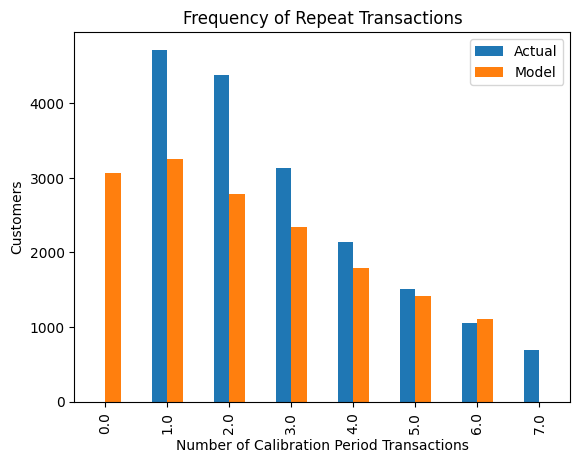

In [120]:
plot_period_transactions(bgf)

In [121]:
bgf.predict(90, grouped_df['frequency'], grouped_df['recency'], grouped_df['T']).sort_values(ascending=False)

master_id
4a7e875e-e6ce-11ea-8f44-000d3a38a36f    4.125816
a4d534a2-5b1b-11eb-8dbd-000d3a38a36f    4.045384
1902bf80-0035-11eb-8341-000d3a38a36f    3.852567
55d54d9e-8ac7-11ea-8ec0-000d3a38a36f    3.667083
f00ad516-c4f4-11ea-98f7-000d3a38a36f    3.603309
                                          ...   
7753092e-a69e-11e9-a2fc-000d3a38a36f    0.090624
9b976186-a6cb-11e9-a2fc-000d3a38a36f    0.090143
f486e45e-a691-11e9-a2fc-000d3a38a36f    0.089904
4eb38320-a691-11e9-a2fc-000d3a38a36f    0.089844
57509c36-a68f-11e9-a2fc-000d3a38a36f    0.089696
Length: 19945, dtype: float64

In [122]:
grouped_df["exp_sales_3_month"] = bgf.predict(90,grouped_df['frequency'], grouped_df['recency'], grouped_df['T'])

In [123]:
grouped_df.sort_values(by="exp_sales_3_month",ascending=False)

,T,frequency,monetary,recency,exp_sales_3_month,exp_sales_6_month
master_id,,,,,,
4a7e875e-e6ce-11ea-8f44-000d3a38a36f,280,28.0,165.297586,278,4.125816,8.250412
a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,471,36.0,166.516455,439,4.045384,7.983452
1902bf80-0035-11eb-8341-000d3a38a36f,233,24.0,97.439600,202,3.852567,7.703914
55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,411,30.0,187.742277,368,3.667083,7.333273
f00ad516-c4f4-11ea-98f7-000d3a38a36f,325,26.0,141.354815,266,3.603309,7.205634
...,...,...,...,...,...,...
7753092e-a69e-11e9-a2fc-000d3a38a36f,2623,1.0,97.855000,2310,0.090624,0.181264
9b976186-a6cb-11e9-a2fc-000d3a38a36f,2639,1.0,80.240000,2374,0.090143,0.180302
f486e45e-a691-11e9-a2fc-000d3a38a36f,2647,1.0,45.240000,2454,0.089904,0.179825


In [124]:
grouped_df["exp_sales_6_month"] = bgf.predict(180,grouped_df['frequency'], grouped_df['recency'], grouped_df['T'])

In [125]:
grouped_df

,T,frequency,monetary,recency,exp_sales_3_month,exp_sales_6_month
master_id,,,,,,
00016786-2f5a-11ea-bb80-000d3a38a36f,560,4.0,155.214000,550,0.579441,1.158881
00034aaa-a838-11e9-a2fc-000d3a38a36f,2031,2.0,89.823333,1733,0.150333,0.300665
000be838-85df-11ea-a90b-000d3a38a36f,411,3.0,180.672500,198,0.574779,1.149558
000c1fe2-a8b7-11ea-8479-000d3a38a36f,359,6.0,124.880000,332,0.983445,1.966891
000f5e3e-9dde-11ea-80cd-000d3a38a36f,323,6.0,231.475714,303,1.034181,2.068361
...,...,...,...,...,...,...
fff1db94-afd9-11ea-b736-000d3a38a36f,781,4.0,159.374000,598,0.468648,0.937296
fff4736a-60a4-11ea-8dd8-000d3a38a36f,394,1.0,159.435000,327,0.353364,0.706727
fffacd34-ae14-11e9-a2fc-000d3a38a36f,961,5.0,163.986667,704,0.472873,0.945745


In [127]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(grouped_df['frequency'], grouped_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.18, q: 0.47, v: 4.06>

In [130]:
ggf.conditional_expected_average_profit(grouped_df['frequency'],
                                        grouped_df['monetary'])

master_id
00016786-2f5a-11ea-bb80-000d3a38a36f    161.350007
00034aaa-a838-11e9-a2fc-000d3a38a36f     98.079284
000be838-85df-11ea-a90b-000d3a38a36f    190.069126
000c1fe2-a8b7-11ea-8479-000d3a38a36f    128.270778
000f5e3e-9dde-11ea-80cd-000d3a38a36f    237.170605
                                           ...    
fff1db94-afd9-11ea-b736-000d3a38a36f    165.646361
fff4736a-60a4-11ea-8dd8-000d3a38a36f    187.269467
fffacd34-ae14-11e9-a2fc-000d3a38a36f    169.092040
fffacecc-ddc3-11e9-a848-000d3a38a36f    154.311874
fffe4b30-18e0-11ea-9213-000d3a38a36f    138.381921
Length: 19945, dtype: float64

In [131]:
grouped_df["exp_average_value"] = ggf.conditional_expected_average_profit(grouped_df['frequency'],
                                        grouped_df['monetary'])

In [133]:
grouped_df["cltv"] = ggf.customer_lifetime_value(bgf,
                                   grouped_df['frequency'],
                                   grouped_df['recency'],
                                   grouped_df['T'],
                                   grouped_df['monetary'],
                                   time=6,
                                   freq="D",
                                   discount_rate=0.01)
grouped_df["cltv"]


master_id
00016786-2f5a-11ea-bb80-000d3a38a36f    180.611657
00034aaa-a838-11e9-a2fc-000d3a38a36f     28.483842
000be838-85df-11ea-a90b-000d3a38a36f    211.047482
000c1fe2-a8b7-11ea-8479-000d3a38a36f    243.694594
000f5e3e-9dde-11ea-80cd-000d3a38a36f    473.832786
                                           ...    
fff1db94-afd9-11ea-b736-000d3a38a36f    149.967320
fff4736a-60a4-11ea-8dd8-000d3a38a36f    127.837038
fffacd34-ae14-11e9-a2fc-000d3a38a36f    154.466854
fffacecc-ddc3-11e9-a848-000d3a38a36f    270.191292
fffe4b30-18e0-11ea-9213-000d3a38a36f    129.859071
Name: cltv, Length: 19945, dtype: float64

In [134]:
grouped_df["segment"] = pd.qcut(grouped_df["cltv"],4,["D","C","B","A"])

In [135]:
grouped_df.groupby("segment")[["frequency","monetary"]].agg(["count","mean","sum"])

frequency                    monetary                          
            count      mean      sum    count        mean           sum
segment                                                                
D            4987  2.472829  12332.0     4987   96.123033  4.793656e+05
C            4986  3.055957  15237.0     4986  130.195613  6.491553e+05
B            4986  4.038708  20137.0     4986  162.230536  8.088815e+05
A            4986  6.237064  31098.0     4986  219.572765  1.094790e+06